In [36]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.ops as ops

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

from src.data_modules.detection_data_module import (
    CbisDdsmDataModuleDetection as DetectionDataModule,
)
from src.models.detection_model import DetectionModel

In [37]:
datamodule = DetectionDataModule(
    root_dir="../data/cbis-ddsm-detec", tumor_type="mass", batch_size=1, num_workers=4
)

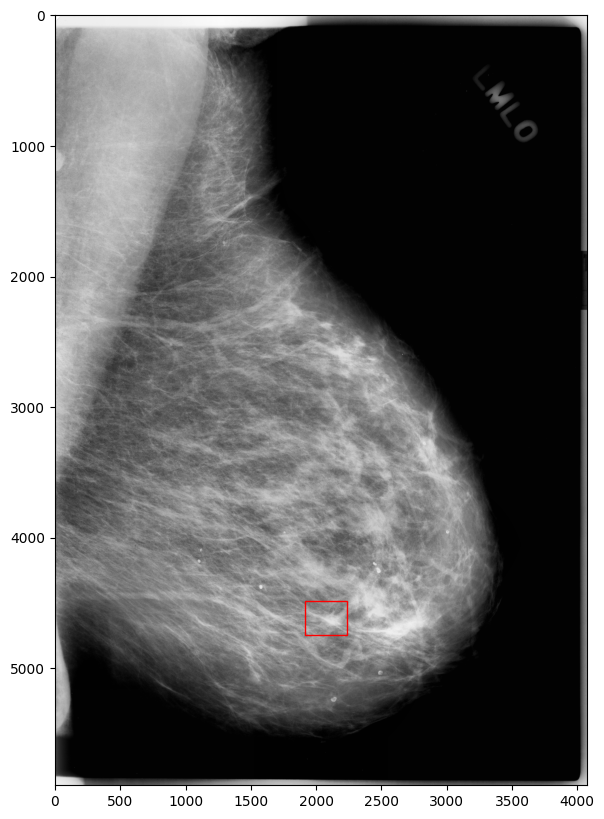

In [38]:
for batch in datamodule.train_dataloader():
    x, y = batch[0][0], batch[1][0]

    image = x.squeeze().numpy()

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    boxes = y["boxes"]
    for i in range(0, len(boxes)):
        xmin, ymin = boxes[i][0], boxes[i][1]
        xmax, ymax = boxes[i][2], boxes[i][3]

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)

    plt.show()
    break

In [39]:
model = DetectionModel(weight_path="../models/mass-detection.ckpt")

Loaded weights from ../models/mass-detection.ckpt


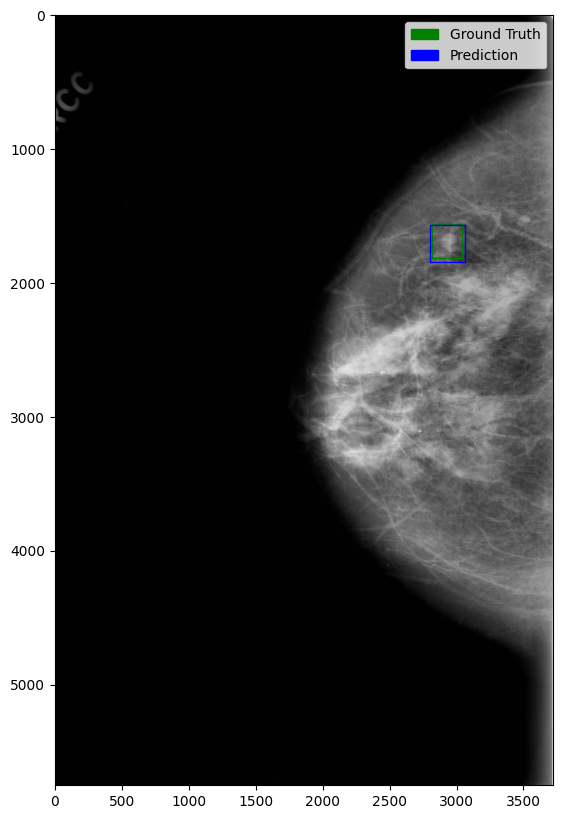

In [45]:
# Get a validation batch
i = 0
for batch in datamodule.val_dataloader():
    if i < 7:
        i += 1
        continue
    x, y = batch[0][0], batch[1][0]

    # Prepare the image
    image = x.squeeze().numpy()

    # Get ground truth boxes
    ground_truth_boxes = y["boxes"]

    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x.unsqueeze(0))
    confidence_threshold = 0.7
    scores = predictions[0]["scores"]
    boxes = predictions[0]["boxes"]
    predicted_boxes = boxes[scores > confidence_threshold]

    iou_threshold = 0.3
    keep_indices = ops.nms(
        predicted_boxes, scores[scores > confidence_threshold], iou_threshold
    )

    # Filtered results
    filtered_boxes = predicted_boxes[keep_indices]
    filtered_scores = scores[scores > confidence_threshold][keep_indices]

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    # Plot ground truth boxes in green
    for box in ground_truth_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="g",
            facecolor="none",
            label="Ground Truth",
        )
        ax.add_patch(rect)

    # Plot predicted boxes in blue
    for box in filtered_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
            label="Prediction",
        )
        ax.add_patch(rect)

    plt.legend(
        handles=[
            patches.Patch(color="green", label="Ground Truth"),
            patches.Patch(color="blue", label="Prediction"),
        ]
    )
    plt.show()
    break